In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/lukas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[2 4 8 9]


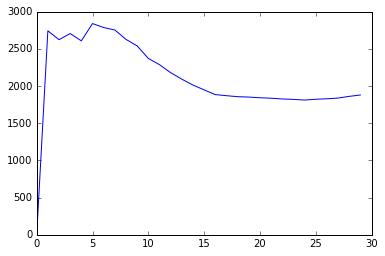

len flat 80200 shape matrix (400, 400)


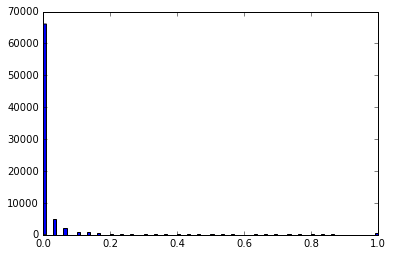

In [87]:
kohonen()

In [11]:
def center_position(points):
    c = np.mean(points, axis=0)
    assert len(c) == len(points[0])
    return c

In [3]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [32]:
def center_for_point_index(p, centers):
    """
    returns the index of the center that is closest to p
    """
    return np.argmin(centers - p)
def center_for_point(p, centers):
    """
    returns the center closest to p
    """
    return centers[center_for_point_index(p, centers)]

In [34]:
def neigh_r(p1, p2, centers, r):
    """
    p1, p2: the two data points
    centers: the neurons
    r: int radius
    returns 1 iff the two points belong to centers at most r hops away from eachother.
    eg neigh_r(0) returns 1 only if p1 and p2 belong to the same center
    
    In this 4x4 map A and B are 2 hops away from eachother.
    [[ 0,  1,  2,  3],
     [ A,  5,  B,  7],
     [ 8,  9, 10, 11],
     [12, 13, 14, 15]]
    """
    i1 = center_for_point_index(p1, centers)
    i2 = center_for_point_index(p2, centers)
    
    if i1 == i2:
        return 1
    
    n =len(centers)
    assert np.sqrt(n) == int(np.sqrt(n)) # make sure n is a square number
    size_k = int(np.sqrt(n))
    
    col_i1 = i1 % size_k
    row_i1 = int(i1 / size_k)
    
    col_i2 = i2 % size_k
    row_i2 = int(i2 / size_k)
    
    dist = max(abs(col_i1 - col_i2), abs(row_i1 - row_i2))
    
    return 1 if dist <= r else 0

In [50]:
def stab_r(stability_matrix):
    """
    Calculates a stability score for the map
    """
    s = 0
    nbr_points = np.shape(stability_matrix)[0]
    for i1 in range(0, nbr_points):
        for i2 in range(i1, nbr_points):
            stab = stability_matrix[i1][i2]
            s += min(1 - stab, stab)
    return s

In [48]:
def update_stab_matrix(stability_matrix, points, centers, t, r):
    nbr_points = np.shape(stability_matrix)[0]
    for i1 in range(0, nbr_points):
        for i2 in range(i1, nbr_points):
            n = neigh_r(points[i1, :], points[i2, :], centers, r)
            stability_matrix[i1][i2] = ((t-1)*stability_matrix[i1][i2] + n) / t
            

In [43]:
def init_stab_matrix(size):
    return np.zeros((size, size))

In [89]:
def kohonen():
    """Example for using create_data, plot_data and som_step.
    """
    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels    
    data = np.array(np.loadtxt('data.txt'))
    labels = np.loadtxt('labels.txt')

    # select 4 digits    
    name = 'Marc-oliver Gewaltig' # REPLACE BY YOUR OWN NAME
    targetdigits = name2digits(name) # assign the four digits that should be used
    print(targetdigits) # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = 2.0
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = 0.1 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE
    
    #set the maximal iteration count
    tmax = 30 # this might or might not work; use your own convergence criterion
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    R = 1
    
    
    data_sample = data[np.random.choice(data.shape[0], data.shape[0]*0.05, replace=False)]
    print("nbr sample: ", len(data_sample))
    stab_matrix = init_stab_matrix(len(data_sample))
    update_stab_matrix(stab_matrix, data_sample, centers, 1, R)
    
    old_centers_center = center_position(centers)
    diff_center = []
    diff_center_mean = []
    stab_scores = []
    for t, i in enumerate(i_random):
        som_step(centers, data[i,:],neighbor,eta,sigma)
        centers_center = center_position(centers)
        diff_center.append(distance(old_centers_center, centers_center))
        diff_center_mean.append(np.mean(diff_center))
        #print(diff_center[-1])
        old_centers_center = centers_center
        
        update_stab_matrix(stab_matrix, data_sample, centers, t+1, R)
        stab_scores.append(stab_r(stab_matrix))
        
        print(".", end="")
        

    
    #plt.plot(diff_center_mean)
    plt.plot(stab_scores)
    plt.show()
    stab_matrix_flat = []
    for i1 in range(0, np.shape(stab_matrix)[0]):
        for i2 in range(i1, np.shape(stab_matrix)[1]):
            stab_matrix_flat.append(stab_matrix[i1][i2])
    
    print("len flat", len(stab_matrix_flat), "shape matrix", np.shape(stab_matrix))
    plt.hist(stab_matrix_flat, bins=100)
"""
    # for visualization, you can use this:
    for i in range(size_k**2):
        plt.subplot(size_k,size_k,i+1)
        
        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plt.axis('off')
        """
   
    

"\n    # for visualization, you can use this:\n    for i in range(size_k**2):\n        plt.subplot(size_k,size_k,i+1)\n        \n        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')\n        plt.axis('off')\n        "

In [5]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

In [6]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [7]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])